<a href="https://colab.research.google.com/github/lo-uis/Team_ChoLab/blob/develop/stl_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import google.colab.drive
google.colab.drive.mount("gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
#!pip install pytorch-lightning

In [0]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm

# **前処理**

In [0]:
# tranform tensor
#前処理できる
#trainデータセットの前処理


transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    #transforms.RandomHorizontalFlip(), #
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #多分正規化
    
    ])

In [0]:
#validationデータセットの前処理
transform_val = transforms.Compose([
    transforms.RandomResizedCrop(224), #サイズ合わせ
    transforms.ToTensor() ,              #型変換(?)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #多分正規化
    ])

In [0]:
#load train
#学習に用いて良い画像は、STL10のtrain,unlabeled画像のみとする。
#STL10のテスト画像は、上記の運営賞に用いるので、validationとして用いること
train = torchvision.datasets.STL10(
    root=".", 
    split='train', 
    folds=None,                          #０〜９で選べるぽい
    transform=transform_train,                     #読み込み時の処理
    target_transform=None, 
    download=False)

In [0]:
#データセットの中身を確認
train

Dataset STL10
    Number of datapoints: 5000
    Root location: .
    Split: train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
#load test for validation
val = torchvision.datasets.STL10(
    root=".", 
    split="test", 
    folds=None,                          
    transform=transform_val,                     
    target_transform=None, 
    download=False)

In [0]:
val

Dataset STL10
    Number of datapoints: 8000
    Root location: .
    Split: test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [0]:
#train[0][0].shape

In [0]:
#可視化してみる
import numpy as np
import matplotlib.pyplot as plt
img = np.transpose(train[1][0],(1,2,0))
img.shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


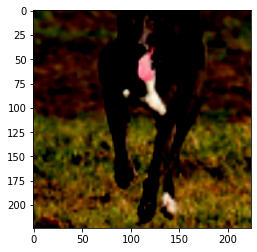

In [0]:
plt.imshow(img)

In [0]:
#type(train[0])

In [0]:
#train[0][0]

In [0]:
#train[1][1]

In [0]:
batch_size = 32

training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False) # testはvaldationとして扱う

#dataloaders_dict = {"train": train_dataloader, "val": val_dataloader} # 辞書オブジェクトにまとめる

# **ただ単にVGG16にぶっこんだ**

In [0]:
#とりあえずVGG16に突っ込んでみる
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()
    self.features = nn.Sequential(
                      nn.Conv2d(3, 64, kernel_size=3,stride=1,padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(64, 64, kernel_size=3,stride=1,padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                    )
    
    self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
    
    self.classifier = nn.Sequential(
                      nn.Linear(in_features=25088, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=4096, bias=True),
                      nn.ReLU(inplace=True),
                      nn.Dropout(p=0.5, inplace=False),
                      nn.Linear(in_features=4096, out_features=1000, bias=True),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)

    return x

In [0]:
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
#vgg16_ver1 = VGG16()
#print(vgg16_ver1)
model = VGG16().to(device)

In [0]:
##パラメーターの設定
model.classifier[6] = nn.Linear(in_features=4096, out_features=10).cuda() # クラス数を10にする
criterion = nn.CrossEntropyLoss() #  損失関数の設定
#optimizer = optim.Adam(model.parameters(),lr=0.001)  # 最適化関数の設定
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)  # 最適化関数の設定

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in training_loader:
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

epoch * 1
training loss: 0.2879, training acc 0.0948
validation loss: 0.2878, validation acc0.1000
epoch * 2
training loss: 0.2879, training acc 0.0952
validation loss: 0.2878, validation acc0.1000
epoch * 3
training loss: 0.2879, training acc 0.0916
validation loss: 0.2878, validation acc0.1000
epoch * 4
training loss: 0.2879, training acc 0.0888
validation loss: 0.2878, validation acc0.1000
epoch * 5
training loss: 0.2879, training acc 0.0838
validation loss: 0.2878, validation acc0.1000
epoch * 6
training loss: 0.2879, training acc 0.0990
validation loss: 0.2878, validation acc0.1000
epoch * 7
training loss: 0.2879, training acc 0.0974
validation loss: 0.2878, validation acc0.1000
epoch * 8
training loss: 0.2879, training acc 0.0888
validation loss: 0.2878, validation acc0.1000


KeyboardInterrupt: ignored

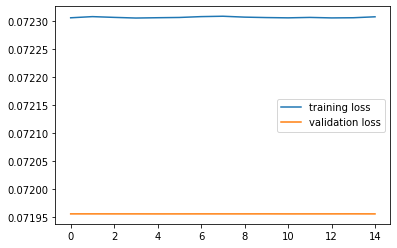

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

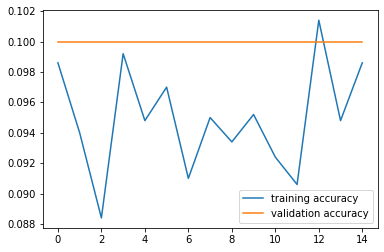

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

# **VGG16転移学習**
参考：https://github.com/YutaroOgawa/pytorch_advanced.git


In [0]:
# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
#GPU使う
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_pretrained = True  # 学習済みのパラメータを使用
model = models.vgg16(pretrained=use_pretrained).to(device)


model.classifier[6] = nn.Linear(in_features=4096, out_features=10).to(device)


In [0]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

In [0]:
# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []

# 学習させるパラメータ名
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0060,  0.0113,  0.0024,  ...,  0.0025,  0.0008,  0.0001],
        [-0.0154,  0.0150,  0.0101,  ...,  0.0150, -0.0141, -0.0133],
        [ 0.0078, -0.0120, -0.0088,  ...,  0.0129,  0.0094,  0.0064],
        ...,
        [-0.0087, -0.0034, -0.0065,  ..., -0.0034,  0.0013,  0.0031],
        [ 0.0046,  0.0125, -0.0068,  ...,  0.0052,  0.0066, -0.0007],
        [ 0.0142, -0.0135, -0.0026,  ...,  0.0015,  0.0103, -0.0134]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 0.0002,  0.0029, -0.0141,  0.0024, -0.0081, -0.0145,  0.0038,  0.0105,
         0.0087,  0.0058], device='cuda:0', requires_grad=True)]


In [0]:
# 最適化手法の設定
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


In [0]:
#EarlyStopipingを導入するために、pytorchtools.pyをアップする
from pytorchtools import EarlyStopping

In [0]:
epochs = 150
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
early_stopping = EarlyStopping(patience=20, verbose=True)  # early stopping patience; how long to wait after last time validation loss improved.

for e in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  model.train() #学習モード
  
  for inputs, labels in tqdm(training_loader):
#     DataLoaderのバッチサイズごとにforで取り出して計算
#     ここのforの処理が終わると1エポック
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
#     一旦パラメーターの勾配をゼロにして
    optimizer.zero_grad()
#     勾配の計算
    loss.backward()
#     学習
    optimizer.step()
    
#     分類わけなので、もっとも数字が大きいものをpredictとする
#     バッチ処理しているので2次元目で比較
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
#     ラベルと合っているものを足し合わせてaccuracy計算
    running_corrects += torch.sum(preds == labels.data)
  
  model.eval() #検証モード
#     pytorchでは勾配の計算の高速化のため、パラメーターを保持しているがテスト時はいらないので止める
  with torch.no_grad():
    for val_inputs, val_labels in tqdm(validation_loader):
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)
      
      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)
      
#   学習過程を記録
  epoch_loss = running_loss/len(training_loader.dataset)
  epoch_acc = running_corrects.float()/ len(training_loader.dataset)
  running_loss_history.append(epoch_loss)
  running_corrects_history.append(epoch_acc)
  
  val_epoch_loss = val_running_loss/len(validation_loader.dataset)
#     print('len-validation_loader :'+str(len(validation_loader)))
#     print('len-validation_loader :'+str(len(validation_loader.dataset)))
  val_epoch_acc = val_running_corrects.float()/len(validation_loader.dataset)
  val_running_loss_history.append(val_epoch_loss)
  val_running_corrects_history.append(val_epoch_acc)
  
  print('epoch *', (e+1))
  print('training loss: {:.4f}, training acc {:.4f}'.format(epoch_loss, epoch_acc.item()))
  print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss,val_epoch_acc.item()))

  early_stopping(val_epoch_loss, model)
        
  if early_stopping.early_stop:
      print("Early stopping")
      break
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)



  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:00<00:43,  3.58it/s]

  1%|▏         | 2/157 [00:00<00:40,  3.85it/s]

  2%|▏         | 3/157 [00:00<00:37,  4.07it/s]

  3%|▎         | 4/157 [00:00<00:36,  4.22it/s]

  3%|▎         | 5/157 [00:01<00:35,  4.30it/s]

  4%|▍         | 6/157 [00:01<00:34,  4.42it/s]

  4%|▍         | 7/157 [00:01<00:33,  4.48it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.57it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.58it/s]

  6%|▋         | 10/157 [00:02<00:32,  4.58it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.61it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.63it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.66it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.65it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.59it/s]

 10%|█         | 16/157 [00:03<00:30,  4.62it/s]

 11%|█         | 17/157 [00:03<00:30,  4.63it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.62it/s]

 12%|█▏        | 19/157 [00:04<00:30,  4.57it/s]

 13%|█▎        |

epoch * 1
training loss: 0.0149, training acc 0.8342
validation loss: 0.0140, validation acc0.8433
Validation loss decreased (inf --> 0.013992).  Saving model ...




  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:00<00:40,  3.82it/s]

  1%|▏         | 2/157 [00:00<00:38,  4.00it/s]

  2%|▏         | 3/157 [00:00<00:36,  4.18it/s]

  3%|▎         | 4/157 [00:00<00:35,  4.33it/s]

  3%|▎         | 5/157 [00:01<00:34,  4.44it/s]

  4%|▍         | 6/157 [00:01<00:33,  4.51it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.56it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.61it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.65it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.68it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.69it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.72it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.70it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.73it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.67it/s]

 10%|█         | 16/157 [00:03<00:30,  4.66it/s]

 11%|█         | 17/157 [00:03<00:29,  4.68it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.69it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        |

epoch * 2
training loss: 0.0151, training acc 0.8236
validation loss: 0.0141, validation acc0.8396
EarlyStopping counter: 1 out of 20




  1%|          | 1/157 [00:00<00:32,  4.82it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.74it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.74it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.73it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.72it/s]

  4%|▍         | 6/157 [00:01<00:31,  4.73it/s]

  4%|▍         | 7/157 [00:01<00:31,  4.73it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.72it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.73it/s]

  6%|▋         | 10/157 [00:02<00:30,  4.75it/s]

  7%|▋         | 11/157 [00:02<00:30,  4.71it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.75it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.73it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.76it/s]

 10%|▉         | 15/157 [00:03<00:29,  4.76it/s]

 10%|█         | 16/157 [00:03<00:29,  4.75it/s]

 11%|█         | 17/157 [00:03<00:29,  4.75it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.74it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.72it/s]

 13%|█▎        | 20/157 [00:04<00:28,  4.76it/s]

 13%|█▎

epoch * 3
training loss: 0.0151, training acc 0.8276
validation loss: 0.0141, validation acc0.8375
EarlyStopping counter: 2 out of 20




  1%|          | 1/157 [00:00<00:32,  4.77it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.76it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.75it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.70it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.70it/s]

  4%|▍         | 7/157 [00:01<00:31,  4.69it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.66it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.66it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.70it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.67it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.71it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.66it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.68it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.69it/s]

 10%|█         | 16/157 [00:03<00:29,  4.73it/s]

 11%|█         | 17/157 [00:03<00:29,  4.71it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.72it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.72it/s]

 13%|█▎

epoch * 4
training loss: 0.0152, training acc 0.8260
validation loss: 0.0142, validation acc0.8376
EarlyStopping counter: 3 out of 20




  1%|          | 1/157 [00:00<00:33,  4.66it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.69it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.68it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.72it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.66it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.70it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.68it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.69it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.70it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.70it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.67it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.68it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.69it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.69it/s]

 10%|█         | 16/157 [00:03<00:30,  4.69it/s]

 11%|█         | 17/157 [00:03<00:29,  4.69it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.70it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.67it/s]

 13%|█▎

epoch * 5
training loss: 0.0148, training acc 0.8294
validation loss: 0.0138, validation acc0.8416
Validation loss decreased (0.013992 --> 0.013771).  Saving model ...




  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:00<00:33,  4.69it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.67it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.67it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.69it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.67it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.70it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.68it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.71it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.69it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.71it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.69it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.69it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.67it/s]

 10%|█         | 16/157 [00:03<00:29,  4.71it/s]

 11%|█         | 17/157 [00:03<00:29,  4.69it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.66it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.66it/s]

 13%|█▎        |

epoch * 6
training loss: 0.0146, training acc 0.8322
validation loss: 0.0135, validation acc0.8481
Validation loss decreased (0.013771 --> 0.013550).  Saving model ...




  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:00<00:42,  3.67it/s]

  1%|▏         | 2/157 [00:00<00:39,  3.92it/s]

  2%|▏         | 3/157 [00:00<00:37,  4.13it/s]

  3%|▎         | 4/157 [00:00<00:35,  4.29it/s]

  3%|▎         | 5/157 [00:01<00:34,  4.41it/s]

  4%|▍         | 6/157 [00:01<00:33,  4.50it/s]

  4%|▍         | 7/157 [00:01<00:33,  4.52it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.59it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.63it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.64it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.68it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.69it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.70it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.70it/s]

 10%|█         | 16/157 [00:03<00:30,  4.66it/s]

 11%|█         | 17/157 [00:03<00:30,  4.66it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.69it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.68it/s]

 13%|█▎        |

epoch * 7
training loss: 0.0145, training acc 0.8366
validation loss: 0.0141, validation acc0.8356
EarlyStopping counter: 1 out of 20




  1%|          | 1/157 [00:00<00:33,  4.66it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.70it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.60it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.64it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.65it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.65it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.65it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.65it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.68it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.67it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.70it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.67it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.68it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.68it/s]

 10%|█         | 16/157 [00:03<00:29,  4.72it/s]

 11%|█         | 17/157 [00:03<00:29,  4.70it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.72it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.72it/s]

 13%|█▎

epoch * 8
training loss: 0.0150, training acc 0.8262
validation loss: 0.0138, validation acc0.8440
EarlyStopping counter: 2 out of 20




  1%|          | 1/157 [00:00<00:33,  4.68it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.71it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.65it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.64it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.66it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.67it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.67it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.69it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.69it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.69it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.65it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.65it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.66it/s]

 10%|█         | 16/157 [00:03<00:30,  4.69it/s]

 11%|█         | 17/157 [00:03<00:29,  4.67it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.70it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.71it/s]

 13%|█▎

epoch * 9
training loss: 0.0145, training acc 0.8316
validation loss: 0.0138, validation acc0.8453
EarlyStopping counter: 3 out of 20




  1%|          | 1/157 [00:00<00:32,  4.80it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.77it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.76it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.74it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.73it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.70it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.68it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.71it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.70it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.71it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.64it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.69it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.68it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.70it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.69it/s]

 10%|█         | 16/157 [00:03<00:30,  4.66it/s]

 11%|█         | 17/157 [00:03<00:30,  4.66it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.67it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.67it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.67it/s]

 13%|█▎

epoch * 10
training loss: 0.0142, training acc 0.8374
validation loss: 0.0142, validation acc0.8360
EarlyStopping counter: 4 out of 20




  1%|          | 1/157 [00:00<00:32,  4.74it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.74it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.69it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.72it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.69it/s]

  4%|▍         | 6/157 [00:01<00:31,  4.72it/s]

  4%|▍         | 7/157 [00:01<00:31,  4.70it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.67it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.68it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.69it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.69it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.73it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.66it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.67it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.67it/s]

 10%|█         | 16/157 [00:03<00:30,  4.69it/s]

 11%|█         | 17/157 [00:03<00:29,  4.69it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.68it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.68it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.69it/s]

 13%|█▎

epoch * 11
training loss: 0.0144, training acc 0.8396
validation loss: 0.0139, validation acc0.8405
EarlyStopping counter: 5 out of 20




  1%|          | 1/157 [00:00<00:33,  4.62it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.65it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.66it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.67it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.68it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.69it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.69it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.66it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.70it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.69it/s]

  9%|▉         | 14/157 [00:02<00:30,  4.71it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.63it/s]

 10%|█         | 16/157 [00:03<00:30,  4.68it/s]

 11%|█         | 17/157 [00:03<00:29,  4.67it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.71it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.69it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.69it/s]

 13%|█▎

epoch * 12
training loss: 0.0139, training acc 0.8440
validation loss: 0.0140, validation acc0.8423
EarlyStopping counter: 6 out of 20




  1%|          | 1/157 [00:00<00:34,  4.58it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.63it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.61it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.62it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.62it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.61it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.63it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.62it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.64it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.58it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.62it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.60it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.61it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.62it/s]

 10%|█         | 16/157 [00:03<00:30,  4.63it/s]

 11%|█         | 17/157 [00:03<00:30,  4.62it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.65it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.64it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.61it/s]

 13%|█▎

epoch * 13
training loss: 0.0143, training acc 0.8388
validation loss: 0.0140, validation acc0.8431
EarlyStopping counter: 7 out of 20




  1%|          | 1/157 [00:00<00:33,  4.67it/s]

  1%|▏         | 2/157 [00:00<00:32,  4.70it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.66it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 5/157 [00:01<00:33,  4.61it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.65it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.63it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.63it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.64it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.65it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.64it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.58it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.60it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.59it/s]

 10%|█         | 16/157 [00:03<00:30,  4.63it/s]

 11%|█         | 17/157 [00:03<00:30,  4.62it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.63it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.64it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.65it/s]

 13%|█▎

epoch * 14
training loss: 0.0147, training acc 0.8294
validation loss: 0.0136, validation acc0.8448
EarlyStopping counter: 8 out of 20




  1%|          | 1/157 [00:00<00:33,  4.59it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.61it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 5/157 [00:01<00:33,  4.59it/s]

  4%|▍         | 6/157 [00:01<00:33,  4.56it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.58it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.62it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.61it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.64it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.60it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.63it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.64it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.66it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.63it/s]

 10%|█         | 16/157 [00:03<00:30,  4.61it/s]

 11%|█         | 17/157 [00:03<00:30,  4.63it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.62it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.63it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.64it/s]

 13%|█▎

epoch * 15
training loss: 0.0146, training acc 0.8314
validation loss: 0.0136, validation acc0.8430
EarlyStopping counter: 9 out of 20




  1%|          | 1/157 [00:00<00:33,  4.59it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.64it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.58it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.61it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.63it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.63it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.66it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.63it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.66it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.65it/s]

  8%|▊         | 12/157 [00:02<00:30,  4.69it/s]

  8%|▊         | 13/157 [00:02<00:30,  4.66it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.69it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.68it/s]

 10%|█         | 16/157 [00:03<00:30,  4.67it/s]

 11%|█         | 17/157 [00:03<00:30,  4.66it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.66it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.66it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.68it/s]

 13%|█▎

epoch * 16
training loss: 0.0144, training acc 0.8334
validation loss: 0.0138, validation acc0.8441
EarlyStopping counter: 10 out of 20




  1%|          | 1/157 [00:00<00:33,  4.64it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.65it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.66it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.63it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.66it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.57it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.59it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.59it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.62it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.61it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.62it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.62it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.65it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.63it/s]

 10%|█         | 16/157 [00:03<00:30,  4.65it/s]

 11%|█         | 17/157 [00:03<00:30,  4.63it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.64it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.65it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.65it/s]

 13%|█▎

epoch * 17
training loss: 0.0146, training acc 0.8324
validation loss: 0.0137, validation acc0.8418
EarlyStopping counter: 11 out of 20




  1%|          | 1/157 [00:00<00:33,  4.62it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.65it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.65it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.62it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.64it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.61it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.61it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.60it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.61it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.60it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.63it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.62it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.59it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.59it/s]

 10%|█         | 16/157 [00:03<00:30,  4.62it/s]

 11%|█         | 17/157 [00:03<00:30,  4.62it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.65it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.60it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.63it/s]

 13%|█▎

epoch * 18
training loss: 0.0145, training acc 0.8310
validation loss: 0.0136, validation acc0.8465
EarlyStopping counter: 12 out of 20




  1%|          | 1/157 [00:00<00:33,  4.60it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.61it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.64it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.66it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.65it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.65it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.64it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.66it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.64it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.61it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.62it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.64it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.62it/s]

 10%|█         | 16/157 [00:03<00:30,  4.63it/s]

 11%|█         | 17/157 [00:03<00:30,  4.62it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.66it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.66it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.68it/s]

 13%|█▎

epoch * 19
training loss: 0.0146, training acc 0.8320
validation loss: 0.0140, validation acc0.8401
EarlyStopping counter: 13 out of 20




  1%|          | 1/157 [00:00<00:33,  4.62it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.64it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.60it/s]

  3%|▎         | 5/157 [00:01<00:33,  4.60it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.63it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.63it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.64it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.59it/s]

  6%|▋         | 10/157 [00:02<00:32,  4.57it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.60it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.62it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.63it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.65it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.63it/s]

 10%|█         | 16/157 [00:03<00:30,  4.66it/s]

 11%|█         | 17/157 [00:03<00:30,  4.64it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.67it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.65it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.65it/s]

 13%|█▎

epoch * 20
training loss: 0.0141, training acc 0.8384
validation loss: 0.0136, validation acc0.8459
EarlyStopping counter: 14 out of 20




  1%|          | 1/157 [00:00<00:33,  4.64it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.67it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.66it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.67it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.68it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.67it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.62it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.65it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.62it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.65it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.66it/s]

  8%|▊         | 12/157 [00:02<00:32,  4.51it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.53it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.60it/s]

 10%|▉         | 15/157 [00:03<00:31,  4.58it/s]

 10%|█         | 16/157 [00:03<00:30,  4.63it/s]

 11%|█         | 17/157 [00:03<00:30,  4.58it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.61it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.61it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.64it/s]

 13%|█▎

epoch * 21
training loss: 0.0145, training acc 0.8332
validation loss: 0.0136, validation acc0.8461
EarlyStopping counter: 15 out of 20




  1%|          | 1/157 [00:00<00:33,  4.62it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.64it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.64it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.67it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.64it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.65it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.62it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.65it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.64it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.61it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.62it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.64it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.64it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.64it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.61it/s]

 10%|█         | 16/157 [00:03<00:30,  4.64it/s]

 11%|█         | 17/157 [00:03<00:30,  4.63it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.65it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.64it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.63it/s]

 13%|█▎

epoch * 22
training loss: 0.0146, training acc 0.8320
validation loss: 0.0141, validation acc0.8388
EarlyStopping counter: 16 out of 20




  1%|          | 1/157 [00:00<00:34,  4.58it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.62it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.60it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.62it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.62it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.63it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.59it/s]

  5%|▌         | 8/157 [00:01<00:32,  4.56it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.58it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.61it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.61it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.65it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.60it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.61it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.63it/s]

 10%|█         | 16/157 [00:03<00:30,  4.64it/s]

 11%|█         | 17/157 [00:03<00:30,  4.62it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.65it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.62it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.64it/s]

 13%|█▎

epoch * 23
training loss: 0.0145, training acc 0.8336
validation loss: 0.0135, validation acc0.8458
Validation loss decreased (0.013550 --> 0.013510).  Saving model ...




  0%|          | 0/157 [00:00<?, ?it/s]

  1%|          | 1/157 [00:00<00:44,  3.50it/s]

  1%|▏         | 2/157 [00:00<00:41,  3.73it/s]

  2%|▏         | 3/157 [00:00<00:38,  3.95it/s]

  3%|▎         | 4/157 [00:00<00:36,  4.14it/s]

  3%|▎         | 5/157 [00:01<00:35,  4.28it/s]

  4%|▍         | 6/157 [00:01<00:34,  4.38it/s]

  4%|▍         | 7/157 [00:01<00:34,  4.40it/s]

  5%|▌         | 8/157 [00:01<00:33,  4.47it/s]

  6%|▌         | 9/157 [00:02<00:33,  4.47it/s]

  6%|▋         | 10/157 [00:02<00:32,  4.55it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.56it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.60it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.57it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.60it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.60it/s]

 10%|█         | 16/157 [00:03<00:30,  4.63it/s]

 11%|█         | 17/157 [00:03<00:30,  4.61it/s]

 11%|█▏        | 18/157 [00:03<00:29,  4.65it/s]

 12%|█▏        | 19/157 [00:04<00:29,  4.64it/s]

 13%|█▎        |

epoch * 24
training loss: 0.0137, training acc 0.8398
validation loss: 0.0140, validation acc0.8400
EarlyStopping counter: 1 out of 20




  1%|          | 1/157 [00:00<00:33,  4.70it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.69it/s]

  2%|▏         | 3/157 [00:00<00:32,  4.68it/s]

  3%|▎         | 4/157 [00:00<00:32,  4.69it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.66it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.64it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.63it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.68it/s]

  6%|▌         | 9/157 [00:01<00:31,  4.66it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.63it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.60it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.64it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.61it/s]

  9%|▉         | 14/157 [00:03<00:31,  4.60it/s]

 10%|▉         | 15/157 [00:03<00:31,  4.57it/s]

 10%|█         | 16/157 [00:03<00:30,  4.58it/s]

 11%|█         | 17/157 [00:03<00:30,  4.60it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.63it/s]

 12%|█▏        | 19/157 [00:04<00:30,  4.56it/s]

 13%|█▎        | 20/157 [00:04<00:30,  4.55it/s]

 13%|█▎

epoch * 25
training loss: 0.0139, training acc 0.8406
validation loss: 0.0140, validation acc0.8406
EarlyStopping counter: 2 out of 20




  1%|          | 1/157 [00:00<00:33,  4.62it/s]

  1%|▏         | 2/157 [00:00<00:33,  4.64it/s]

  2%|▏         | 3/157 [00:00<00:33,  4.61it/s]

  3%|▎         | 4/157 [00:00<00:33,  4.63it/s]

  3%|▎         | 5/157 [00:01<00:32,  4.63it/s]

  4%|▍         | 6/157 [00:01<00:32,  4.65it/s]

  4%|▍         | 7/157 [00:01<00:32,  4.63it/s]

  5%|▌         | 8/157 [00:01<00:31,  4.66it/s]

  6%|▌         | 9/157 [00:01<00:32,  4.62it/s]

  6%|▋         | 10/157 [00:02<00:31,  4.67it/s]

  7%|▋         | 11/157 [00:02<00:31,  4.65it/s]

  8%|▊         | 12/157 [00:02<00:31,  4.61it/s]

  8%|▊         | 13/157 [00:02<00:31,  4.63it/s]

  9%|▉         | 14/157 [00:03<00:30,  4.64it/s]

 10%|▉         | 15/157 [00:03<00:30,  4.62it/s]

 10%|█         | 16/157 [00:03<00:30,  4.65it/s]

 11%|█         | 17/157 [00:03<00:30,  4.58it/s]

 11%|█▏        | 18/157 [00:03<00:30,  4.58it/s]

 12%|█▏        | 19/157 [00:04<00:30,  4.56it/s]

 13%|█▎        | 20/157 [00:04<00:29,  4.62it/s]

 13%|█▎

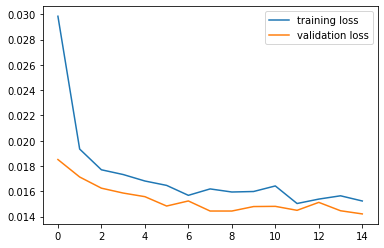

In [0]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

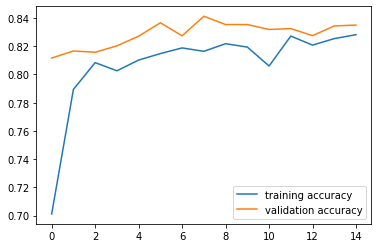

In [0]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [0]:
#学習済みモデルの保存
save_path = './weights.pth'
torch.save(model.state_dict(), save_path)